In [1]:
%load_ext autoreload
%autoreload 2

# Poisson inverse problem (PInv)

Benchmark on the Poisson inverse problem as proposed in the PINNACLE benchmark paper (https://arxiv.org/pdf/2306.08827) (see Appendix B21: (**PInv**)).

We dig through the PINNACLE code database to retrieve the experimental setting (number of collocation points, number of iterations, ...) as well as the reference values of the solution.

In [2]:
seed = 1

In [5]:
import numpy as np
import jax.numpy as jnp

# from PINNACLE
DEFAULT_NUM_DOMAIN_POINTS = 8192 // 10
DEFAULT_NUM_BOUNDARY_POINTS = 2048 // 10

np.random.seed(seed)
noisy_obs = np.random.normal(loc=0, scale=0.1, size=(2500, 1))

def a_ref_dde(xy):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return 1 / (1 + x**2 + y**2 + (x - 1) ** 2 + (y - 1) ** 2)

def a_ref_jinns(xy):
    x, y = xy[0:1], xy[1:2]
    return 1 / (1 + x**2 + y**2 + (x - 1) ** 2 + (y - 1) ** 2)

def u_ref_dde(xy):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

def u_ref_jinns(xy):
    x, y = xy[0:1], xy[1:2]
    return jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y)

def f_src_dde(xy):
    x, y = xy[:, 0:1], xy[:, 1:2]
    return (
        2 * jnp.pi**2 * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y) * a_ref_dde(xy)
        + 2 * jnp.pi * (
            (2 * x + 1) * jnp.cos(jnp.pi * x) * jnp.sin(jnp.pi * y)
            + (2 * y + 1) * jnp.sin(jnp.pi * x) * jnp.cos(jnp.pi * y)
        ) * a_ref_dde(xy) ** 2
    )

def f_src_jinns(xy):
    x, y = xy[0:1], xy[1:2]
    return (
        2 * jnp.pi**2 * jnp.sin(jnp.pi * x) * jnp.sin(jnp.pi * y) * a_ref_jinns(xy)
        + 2 * jnp.pi * (
            (2 * x + 1) * jnp.cos(jnp.pi * x) * jnp.sin(jnp.pi * y)
            + (2 * y + 1) * jnp.sin(jnp.pi * x) * jnp.cos(jnp.pi * y)
        ) * a_ref_jinns(xy) ** 2
    )
    
ref_sol_dde = lambda xy: jnp.concatenate((u_ref_dde(xy), a_ref_dde(xy)), axis=1)
ref_sol_jinns = lambda xy: jnp.concatenate((u_ref_jinns(xy), a_ref_jinns(xy)), axis=1)

## DeepXDE


We use the JAX backend.

Compiling model...
'compile' took 0.041131 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.82e+01, 2.15e-01, 4.40e-01]    [1.82e+01, 2.15e-01, 4.40e-01]    []  
1000      [1.03e-03, 2.78e-05, 3.77e-02]    [1.03e-03, 2.78e-05, 3.77e-02]    []  
2000      [5.09e-04, 4.95e-05, 3.73e-02]    [5.09e-04, 4.95e-05, 3.73e-02]    []  
3000      [2.08e-02, 8.20e-07, 3.77e-02]    [2.08e-02, 8.20e-07, 3.77e-02]    []  
4000      [7.67e-04, 3.32e-07, 3.69e-02]    [7.67e-04, 3.32e-07, 3.69e-02]    []  
5000      [3.18e-04, 1.47e-05, 3.68e-02]    [3.18e-04, 1.47e-05, 3.68e-02]    []  
6000      [2.54e-04, 3.14e-06, 3.66e-02]    [2.54e-04, 3.14e-06, 3.66e-02]    []  
7000      [3.35e-04, 1.43e-07, 3.65e-02]    [3.35e-04, 1.43e-07, 3.65e-02]    []  
8000      [2.35e-04, 1.38e-07, 3.63e-02]    [2.35e-04, 1.38e-07, 3.63e-02]    []  
9000      [2.30e-04, 1.42e-07, 3.62e-02]    [2.30e-04, 1.42e-07, 3.62e-02]    []  
10000     [5.00

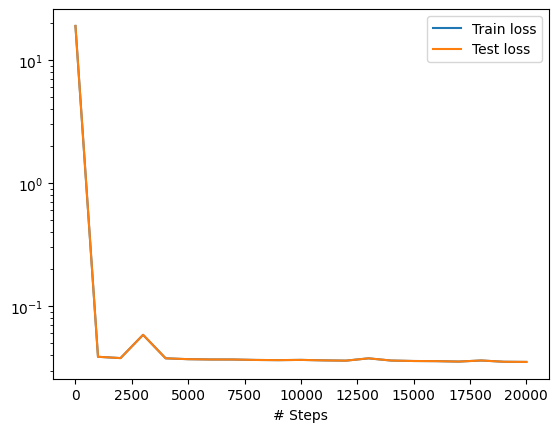

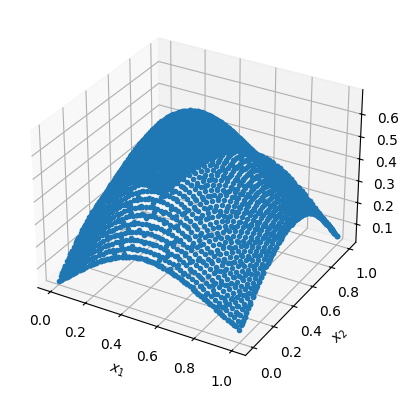

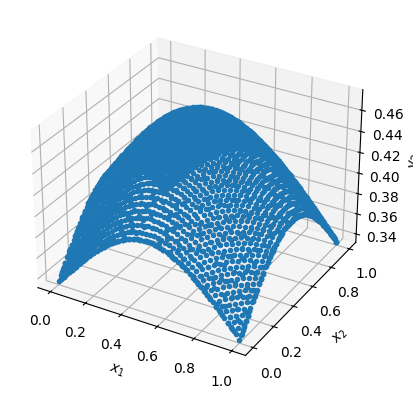

In [6]:
import os
os.environ["DDE_BACKEND"]="jax"
import deepxde as dde

# Determinism may reduce performance in DeepXDE (see doc) but needs to
# be set for a fair comparison with Jinns
# https://deepxde.readthedocs.io/en/stable/modules/deepxde.html#deepxde.config.set_random_seed
dde.config.set_random_seed(seed)

# PDE for JAX
def pde(x, ua):
    ua_val, ua_fn = ua
    u, a = ua_val[:, 0:1], ua_val[:, 1:2]
    u_x, u_x_fn = dde.grad.jacobian(ua, x, i=0, j=0)
    u_y, u_y_fn = dde.grad.jacobian(ua, x, i=0, j=1)
    d_au, _ = dde.grad.jacobian((a * u_x, u_x_fn), x, i=0, j=0) 
    d_au += dde.grad.jacobian((a * u_y, u_y_fn), x, i=0, j=1)[0]
    return d_au + f_src_dde(x)

# PDE for pytorch
# def pde(x, ua):
#     u, a = ua[:, 0:1], ua[:, 1:2]
#     u_x = dde.grad.jacobian(u, x, i=0, j=0)
#     u_y = dde.grad.jacobian(u, x, i=0, j=1)
#     d_au = dde.grad.jacobian(a * u_x, x, i=0, j=0) + dde.grad.jacobian(a * u_y, x, i=0, j=1)
#     return d_au + self.f_src(x)

geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[1, 1])

bc_x = np.linspace(0, 1, 50)
bc_y = np.linspace(0, 1, 50)
bc_x, bc_y = np.meshgrid(bc_x, bc_y)
bc_xy = np.stack((bc_x.reshape(-1), bc_y.reshape(-1))).T

            
bc_a = dde.icbc.DirichletBC(geom, a_ref_dde, (lambda _, on_boundary: on_boundary), 1)

data_loss = dde.icbc.PointSetBC(bc_xy, u_ref_dde(bc_xy) + noisy_obs, 0)

data = dde.data.PDE(
    geom,
    pde,
    [bc_a, data_loss],
    num_domain=DEFAULT_NUM_DOMAIN_POINTS,
    num_boundary=DEFAULT_NUM_BOUNDARY_POINTS,
    # train_distribution="uniform" # this is the default
    # num_test=None # this is the Default, we perform a evaluation callback on the same dataset as the training (see the test column in the training log)
)
net = dde.nn.PFNN([2] + [[50] * 2] * 5 + [2], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## With Jinns

In [5]:
import jax
import equinox as eqx
import jinns
import jax.numpy as jnp
from jax import grad, vmap, random
import optax
import time
import matplotlib.pyplot as plt

key = random.PRNGKey(seed)

In [6]:
eqx_list = (
    (eqx.nn.Linear, 2, 50), # shared inputs are considered
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 1) # 1 for u in one case and 1 for a in another case
)
key, subkey = random.split(key)
ua_pinn, init_ua_nn_params = jinns.utils.create_PPINN(subkey, (eqx_list,) * 2, "nonstatio_PDE", 2, slice_solution=jnp.s_[:1])

In [7]:
n = DEFAULT_NUM_DOMAIN_POINTS
nb = DEFAULT_NUM_BOUNDARY_POINTS
dim = 2
xmin = 0
xmax = 1
ymin = 0
ymax = 1
method = "grid" # equals "uniform" in deepXDE, while "uniform" in jinns equals "pseudo" in deepXDE

train_data = jinns.data.CubicMeshPDEStatio(
    key=subkey,
    n=n,
    nb=nb,
    dim=dim,
    min_pts=(xmin, ymin),
    max_pts=(xmax, ymax),
    method=method,
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/data/_DataGenerators.py:434: UserWarning: Grid sampling is requested in dimension 2 with a non perfect square dataset size (self.n = 819). Modifying self.n to self.n = 841.
  warnings.warn(


In [8]:
# Init parameters for NN and equation
init_params_pinn = jinns.parameters.Params(
    nn_params=init_ua_nn_params,
    eq_params={}
)

In [9]:
from jinns.loss import PDEStatio

class PoissonInv(PDEStatio):
    def equation(self, x, ua, params):
        u_pinn = lambda x, params: jnp.squeeze(ua(x, params)[ua.slice_solution])
        a_times_jac_u = lambda x, params: ua(x, params)[1:2] * jax.jacrev(u_pinn, 0)(x, params)
        return jinns.loss.divergence_rev(x, a_times_jac_u, params, eq_type="statio_PDE")[None] + f_src_jinns(x)

In [10]:
p_loss = PoissonInv()

loss_weights = jinns.loss.LossWeightsPDEStatio(
    dyn_loss=1, observations=1, boundary_loss=1
)

In [11]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    subkey,
    obs_batch_size=None,
    observed_pinn_in=bc_xy,
    observed_values=jax.vmap(u_ref_jinns)(bc_xy) + noisy_obs
)

In [12]:
loss_pinn = jinns.loss.LossPDEStatio(
    u=ua_pinn,
    loss_weights=loss_weights,
    dynamic_loss=p_loss,
    omega_boundary_fun=a_ref_jinns,
    omega_boundary_condition="dirichlet",
    omega_boundary_dim=jnp.s_[1:2],
    params=init_params_pinn,
    obs_slice=jnp.s_[0:1]
)

In [13]:
# Training loop in Jinns
params_pinn = init_params_pinn
tx = optax.adam(learning_rate=1e-3)
n_iter = 20000

In [14]:
params_pinn, total_loss_list_pinn, loss_by_term_dict_pinn, _, _, _, _ , _, _ = jinns.solve(
    init_params=params_pinn,
    data=train_data,
    optimizer=tx,
    loss=loss_pinn,
    n_iter=n_iter,
    verbose=True,
    obs_data=obs_data
)


Compilation took
 6.88190484046936 

[train] Iteration 0: loss value = 21.017351150512695
[train] Iteration 1000: loss value = 0.021489445120096207
[train] Iteration 2000: loss value = 0.01730371080338955
[train] Iteration 3000: loss value = 0.01579119637608528
[train] Iteration 4000: loss value = 0.03893928602337837
[train] Iteration 5000: loss value = 0.017437947914004326
[train] Iteration 6000: loss value = 0.014113073237240314
[train] Iteration 7000: loss value = 0.013756650499999523
[train] Iteration 8000: loss value = 0.02816968970000744
[train] Iteration 9000: loss value = 0.017333094030618668
[train] Iteration 10000: loss value = 0.012891816906630993
[train] Iteration 11000: loss value = 0.012746497988700867
[train] Iteration 12000: loss value = 0.012889474630355835
[train] Iteration 13000: loss value = 0.012732482515275478
[train] Iteration 14000: loss value = 0.012181026861071587
[train] Iteration 15000: loss value = 0.012394092977046967
[train] Iteration 16000: loss value =

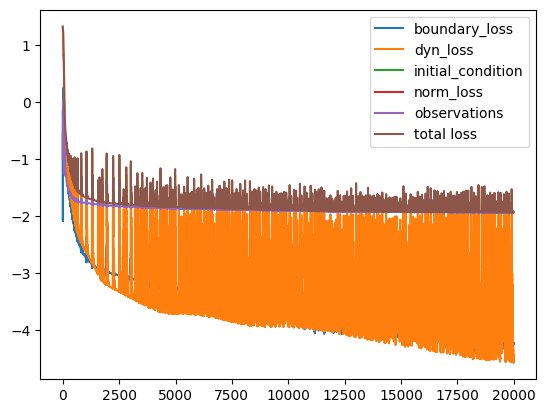

In [15]:
for loss_name, loss_values in loss_by_term_dict_pinn.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list_pinn), label="total loss")
plt.legend()
plt.show()

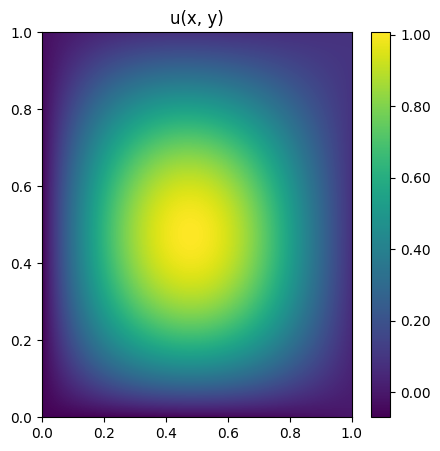

In [16]:
u_est = lambda x: ua_pinn(x, params_pinn)[0]
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.plot.plot2d(u_est, xy_data=val_xydata, times=None, cmap="viridis", figsize=(5, 5), title="u(x, y)")

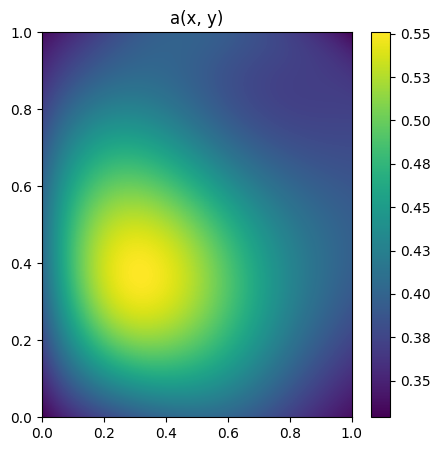

In [17]:
a_est = lambda x: ua_pinn(x, params_pinn)[1]
nx = 1000
val_xydata = [jnp.linspace(xmin, xmax, nx), jnp.linspace(xmin, xmax, nx)]
jinns.plot.plot2d(a_est, xy_data=val_xydata, times=None, cmap="viridis", figsize=(5, 5), title="a(x, y)")

## Comparisons

We have an analytical reference solution so we will evaluate on sampled points from the geometry (https://github.com/i207M/PINNacle/blob/main/src/utils/callbacks.py#L135)

In [18]:
import sys
sys.path.append('../')

from PINNacle_utils import compute_relative_errors

test_x = geom.random_points(2500)
test_y = ref_sol_dde(test_x)

In [19]:
compute_relative_errors(test_y, model.predict(test_x))

l1re=0.16855319, l2re=0.26172224


In [20]:
pred = jax.vmap(ua_pinn, (0, None))(test_x, params_pinn)
compute_relative_errors(test_y, pred)

l1re=0.07009917, l2re=0.087523215
